# The Daubechies D4 Wavelet Tranform

##### All functions and variables declaration

In [1]:
from functions import *
import os
import random
import matplotlib.pyplot as plt
from time import time


#### Daubechies coefficients

In [2]:
################## 4 #################
ROOT2, ROOT3 = np.sqrt(2), np.sqrt(3) 

H_COEFFS4 = np.array([(1 + ROOT3) / (4 * ROOT2),(3 + ROOT3) / (4 * ROOT2), (3 - ROOT3) / (4 * ROOT2), (1 - ROOT3) / (4 * ROOT2)])
G_COEFFS4 = np.array([H_COEFFS4[3],-H_COEFFS4[2],H_COEFFS4[1],-H_COEFFS4[0]])


################## 8 #################
H_COEFFS8 = np.array([0.23037781, 0.71484657, 0.63088076, -0.02798376, -0.18703481, 0.03084138, 0.03288301, -0.01059740])
G_COEFFS8 = np.array([-0.01059740, -0.03288301, 0.03084138, 0.18703481, -0.02798376, -0.63088076, 0.71484657, -0.23037781])


##### Checking Orthonormality

In [3]:
h_coeffs, g_coeffs =  H_COEFFS8, G_COEFFS8
verificar_ortonormalidad(h_coeffs, g_coeffs)

The vectors are orthonormal, the dot product is: -8.673617379884035e-19 and the norm of each vector is (0.9999999931242683, 0.9999999931242683) respectively


## NUMERIC EXAMPLE

## IMAGES EXAMPLES

In [4]:
datarute = r'C:\Users\ZIGH\Documents\ENSEA\INTERNSHIP\CNN\UTKFace-crop_Renamed'

image_files = os.listdir(datarute)
random_index = random.randint(0, len(image_files) - 1)
random_image_filename = image_files[random_index]
random_image_path = os.path.join(datarute, random_image_filename)
print(random_image_path)

C:\Users\ZIGH\Documents\ENSEA\INTERNSHIP\CNN\UTKFace-crop_Renamed\34_0_20170117203227887.jpg


28.0


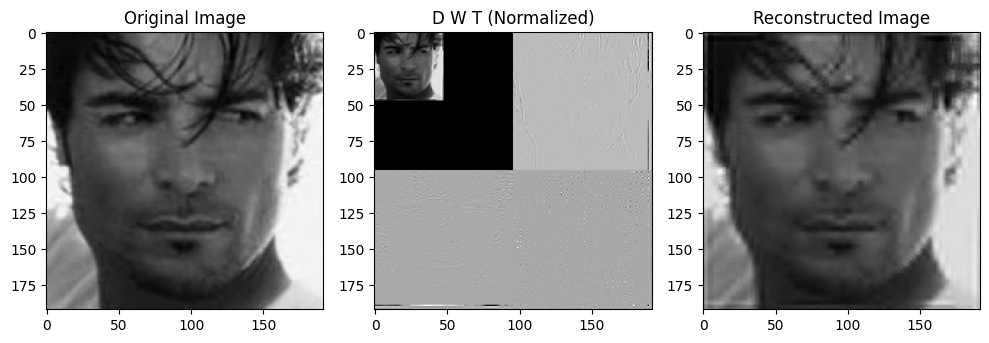

In [17]:
# photo = 'images/foto_dataset1.jpg'
array_photo = jpg_to_pgm(random_image_path)

scale = 2
width = array_photo.shape[0]
daubechies_4 = function_daubechies_coeffs(array_photo, h_coeffs, g_coeffs)


initial_time = time() 

result_img, normalized = daubechies4_wavelet_transform_2D(
    daubechies_4, array_photo, scale, width, h_coeffs, g_coeffs)

################### ZERO ADDING #######################

result_img = zeros(result_img, scale, black_frame="dV")
result_img = zeros(result_img, scale, black_frame="dH")
result_img = zeros(result_img, scale, black_frame="dD")

normalized = zeros(normalized, scale, black_frame="dV")
normalized = zeros(normalized, scale, black_frame="dH")
normalized = zeros(normalized, scale, black_frame="dD")

#######################################################

reconstructed = inverse_daubechies4_wavelet_transform_2D(
    daubechies_4, result_img, scale, width, h_coeffs, g_coeffs)

final_time = time()
# print(final_time - initial_time)

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(array_photo, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(normalized, cmap='gray')
axes[1].set_title('D W T (Normalized)')
axes[2].imshow(reconstructed, cmap='gray', vmin =  0)
axes[2].set_title('Reconstructed Image')

plt.tight_layout()
plt.show()
